In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import xlsxwriter

### Arguments and train data

In [2]:
r = [0.05, 0.25, 0.5, 1, 2] # learning rate
momentum = [0, 0.5, 1] #term of momentum

# train data with binary codification
xor_binary = np.array([
    0, 0,
    0, 1,
    1, 0,
    1, 1
]).reshape(4, 2)

# train data with bipolar codification
xor_bipolar = np.array([
    -1, -1,
    -1, 1,
    1, -1,
    1, 1
]).reshape(4, 2)

y_train = np.array([0, 1, 1, 0])

### Test data shuffled

In [3]:
# test with xor shuffled 
indexes = np.arange(y_train.shape[0])
np.random.shuffle(indexes)

xor_bin_test = np.zeros(xor_binary.shape)
xor_bipolar_test = np.zeros(xor_bipolar.shape)
y_test = np.zeros(y_train.shape[0])

for index in range(indexes.shape[0]):
    xor_bin_test[index] = xor_binary[indexes[index]]
    xor_bipolar_test[index] = xor_bipolar[indexes[index]]
    y_test[index] = y_train[indexes[index]]
    

print(xor_bin_test)
print(xor_bipolar_test)
print(y_test)

[[0. 1.]
 [1. 0.]
 [1. 1.]
 [0. 0.]]
[[-1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [-1. -1.]]
[1. 1. 0. 0.]


### Function to train the neural network

In [4]:
def mlp_classification(x_train, y_train, x_test, y_test, learning_rate, momentum, shuffle_data):
    mlp = None
    max_error = 0.1
    currentLoss = 10
    # only returns a neural network when the error is less than maximum error
    while currentLoss > max_error:
        
        mlp = MLPClassifier(solver='sgd', shuffle=shuffle_data, activation="relu", 
                    max_iter=10_000, tol=1e-6, hidden_layer_sizes=(8,),
                    momentum=momentum, learning_rate_init=learning_rate , verbose=False)
        
        # trains the neural network and get the 
        mlp.fit(x_train, y_train)
        currentLoss = min(mlp.loss_curve_)
    
    print('Score: ', mlp.score(x_test, y_test))
    print('Number of iterations: ', mlp.n_iter_)
    print('Loss: ', currentLoss)
    
    return mlp

<hr style="border:1px  solid black"> </hr>

# Tests

### Test with a single example

In [5]:
mlp = mlp_classification(xor_binary, y_train, xor_bin_test, y_test, r[0], momentum[0], False)
y2 = mlp.predict(xor_bin_test)
print(confusion_matrix(y_test, y2))

Score:  1.0
Number of iterations:  5252
Loss:  0.003957516633941976
[[2 0]
 [0 2]]


### Plot decision region

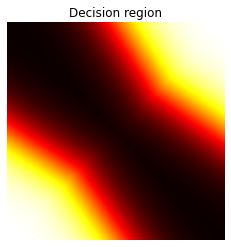

In [6]:
step = .01
        
x_min, x_max = xor_binary[:, 0].min(), xor_binary[:, 0].max()
y_min, y_max = xor_binary[:, 1].min(), xor_binary[:, 1].max()
grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
        
prob = mlp.predict_proba(np.c_[grid_x.ravel(), grid_y.ravel()])[:,1]
prob = prob.reshape(grid_x.shape)
plt.imshow(prob, cmap=plt.cm.hot)
plt.title('Decision region')
plt.axis('off')
plt.show()

## Test for learning rate and momentum without shuffle data

In [10]:
workbook = xlsxwriter.Workbook("R_M.xlsx")
worksheet = workbook.add_worksheet()

x_colm = 0
y_colm = 2


for m in momentum:
    x_colm = 0
    print("----- Momentum:" + str(m) + " -----")
    
    for alpha in r:
        print("----- Learning rate", alpha, " -----")
        results = []
        for i in range(10):
            print("-- " + str(i) + " --")
            mlp = mlp_classification(xor_bipolar, y_train, xor_bipolar_test, y_test, alpha, m, False)
            results.append(mlp.n_iter_)
            
        worksheet.write_column(y_colm, x_colm, results)
        worksheet.write(y_colm-2, 0, "Momentum: ("+str(m)+"), Learning rate: ")
        worksheet.write_row(y_colm-1, 0, r)
        x_colm += 1
    
    y_colm += 13


workbook.close()

----- Momentum:0 -----
----- Learning rate 0.05  -----
-- 0 --
Score:  1.0
Number of iterations:  3147
Loss:  0.00261077077412534
-- 1 --
Score:  1.0
Number of iterations:  3088
Loss:  0.002591087505236836
-- 2 --
Score:  1.0
Number of iterations:  3473
Loss:  0.0028039648884732003
-- 3 --
Score:  1.0
Number of iterations:  3740
Loss:  0.00291887081124959
-- 4 --
Score:  1.0
Number of iterations:  2853
Loss:  0.002582553159753622
-- 5 --
Score:  1.0
Number of iterations:  2751
Loss:  0.002574890493788389
-- 6 --
Score:  1.0
Number of iterations:  3024
Loss:  0.002631305893631765
-- 7 --
Score:  1.0
Number of iterations:  3331
Loss:  0.0028204299051379344
-- 8 --
Score:  1.0
Number of iterations:  3412
Loss:  0.0028045968981034062
-- 9 --
Score:  1.0
Number of iterations:  3726
Loss:  0.002875620122284799
----- Learning rate 0.25  -----
-- 0 --
Score:  1.0
Number of iterations:  1096
Loss:  0.0014088481597065194
-- 1 --
Score:  1.0
Number of iterations:  1554
Loss:  0.001576448627626718

## Test with shuffled data and momentum 1

In [8]:
workbook = xlsxwriter.Workbook("shuffle_data.xlsx")
worksheet = workbook.add_worksheet()

momentum_result = 1


x_colm = 0
y_colm = 2

    
for alpha in r:
    print("----- Learning rate", alpha, " -----")
    results = []
    for i in range(10):
        print("-- " + str(i) + " --")
        mlp = mlp_classification(xor_bipolar, y_train, xor_bipolar_test, y_test, alpha, momentum_result, True)
        results.append(mlp.n_iter_)
            
    worksheet.write_column(y_colm, x_colm, results)
    worksheet.write(y_colm-2, 0, "Momentum: ("+str(m)+"), Learning rate: ")
    worksheet.write_row(y_colm-1, 0, r)
    x_colm += 1


workbook.close()

----- Learning rate 0.05  -----
-- 0 --
Score:  1.0
Number of iterations:  70
Loss:  0.0015357971498001519
-- 1 --
Score:  1.0
Number of iterations:  52
Loss:  0.0010953499918508322
-- 2 --
Score:  1.0
Number of iterations:  53
Loss:  0.001101574308242222
-- 3 --
Score:  1.0
Number of iterations:  76
Loss:  0.0031253082598034225
-- 4 --
Score:  1.0
Number of iterations:  84
Loss:  0.0033209814428392147
-- 5 --
Score:  1.0
Number of iterations:  62
Loss:  0.0019225440835296337
-- 6 --
Score:  1.0
Number of iterations:  57
Loss:  0.0012588752909788415
-- 7 --
Score:  1.0
Number of iterations:  83
Loss:  0.0038485019199408395
-- 8 --
Score:  1.0
Number of iterations:  55
Loss:  0.0012673290297498725
-- 9 --
Score:  1.0
Number of iterations:  50
Loss:  0.0009439068576378042
----- Learning rate 0.25  -----
-- 0 --
Score:  1.0
Number of iterations:  39
Loss:  0.001871523671755911
-- 1 --
Score:  1.0
Number of iterations:  32
Loss:  0.00124700470644112
-- 2 --
Score:  1.0
Number of iterations

In [9]:
workbook = xlsxwriter.Workbook("bin.xlsx")
worksheet = workbook.add_worksheet()

momentum_result = 1


x_colm = 0
y_colm = 2

    
for alpha in r:
    print("----- Learning rate", alpha, " -----")
    results = []
    for i in range(10):
        print("-- " + str(i) + " --")
        mlp = mlp_classification(xor_binary, y_train, xor_bin_test, y_test, alpha, momentum_result, False)
        results.append(mlp.n_iter_)
            
    worksheet.write_column(y_colm, x_colm, results)
    worksheet.write(y_colm-2, 0, "Momentum: ("+str(m)+"), Learning rate: ")
    worksheet.write_row(y_colm-1, 0, r)
    x_colm += 1


workbook.close()

----- Learning rate 0.05  -----
-- 0 --
Score:  1.0
Number of iterations:  100
Loss:  0.00384391691123334
-- 1 --
Score:  1.0
Number of iterations:  98
Loss:  0.0032982821382562693
-- 2 --
Score:  1.0
Number of iterations:  98
Loss:  0.004052850928149398
-- 3 --
Score:  1.0
Number of iterations:  84
Loss:  0.001968349913242712
-- 4 --
Score:  1.0
Number of iterations:  79
Loss:  0.0018196982586066548
-- 5 --
Score:  1.0
Number of iterations:  108
Loss:  0.0037230188313848982
-- 6 --
Score:  1.0
Number of iterations:  70
Loss:  0.0017675937656734299
-- 7 --
Score:  1.0
Number of iterations:  153
Loss:  0.007199490965925941
-- 8 --
Score:  1.0
Number of iterations:  80
Loss:  0.0018926867555338184
-- 9 --
Score:  1.0
Number of iterations:  93
Loss:  0.003373845328505021
----- Learning rate 0.25  -----
-- 0 --
Score:  1.0
Number of iterations:  46
Loss:  0.0023900100587000406
-- 1 --
Score:  1.0
Number of iterations:  46
Loss:  0.002169825058333614
-- 2 --
Score:  1.0
Number of iterations